In [5]:
using Markdown
using InteractiveUtils
using Plots
using NNlib # directly invoking NN primitives used by Flux
#maybe use this always instead, if Flux has higher overhead (compilation, performance)
using DSP #signal processing pkg for standard conv operations
using BenchmarkTools
using Flux

In [6]:
#define grid
M = 10;
N = 10;
Δx = 0.5;
Δy = 0.5;
xl = Int64(M/Δx + 1);
yl = Int64(N/Δy + 1);
xx = collect(0:Δx:M);
yy = collect(0:Δy:N);
xgrid = repeat(xx,1,xl);
ygrid = repeat(yy,1,yl);

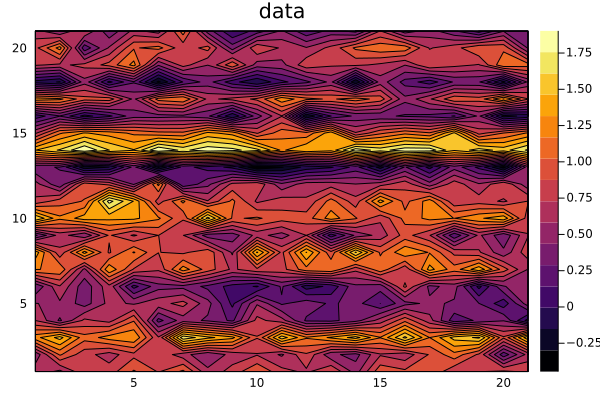

In [7]:
ϕ = abs.(sin.(randn(xl,yl) * xgrid) + cos.(randn(xl,yl) * ygrid)) + 0.25 * randn(xl,yl);
#modified ϕ with extra channel and batch dimensions for conv layer
ϕconv = Float32.(reshape(ϕ,(xl,yl,1,1)));
#conv ϕ with extra padding for first order derivative at the bdry.
p1 = contourf(ϕ, title="data")

In [8]:
ϕ

21×21 Matrix{Float64}:
  0.682347    0.541442   0.848884   …   0.871894    0.904233    0.852207
  0.463713    1.04319    0.785423       0.847699    0.192149    0.641056
  1.25964     1.51932    1.07816        1.6394      0.899925    1.5831
  0.728824    0.410908   0.765077       0.316269    0.425651   -0.0692354
  0.585949    0.554703   0.363667       0.291048    0.0476379   0.52454
  0.298854    0.714159   0.336262   …  -0.0527293   0.421822    0.559273
  1.1744      1.14827    0.544637       1.42449     0.943808    0.571648
  1.40823     0.762943   1.37082        0.74953     0.470133    0.836758
  0.255071    0.648191   0.45738        0.613226    0.322566    0.721892
  1.61096     1.20242    1.39067        1.29043     1.41882     0.788612
  0.758499    0.955257   1.03145    …   0.808184    0.703105    0.882436
  0.642087    0.319859   0.958668       0.598035    0.872165    0.467045
  0.313688    0.281617  -0.258976       0.0993321  -0.368403    0.539623
  1.45783     1.62738    1.901

In [9]:
ϕconvPadded = Array{Float64}(undef,xl+2,yl+2)
ϕconvPadded[2:end-1,2:end-1] = copy(ϕ)
#rows
ϕconvPadded[1,2:end-1] = ϕconvPadded[2,2:end-1]
ϕconvPadded[end,2:end-1] = ϕconvPadded[end-1,2:end-1]
#columns
ϕconvPadded[2:end-1,1] = ϕconvPadded[2:end-1,2]
ϕconvPadded[2:end,end] = ϕconvPadded[2:end,end-1]
ϕconvPadded = Float32.(reshape(ϕconvPadded,(xl+2,yl+2,1,1)));

## Computing $\partial$ derivatives with Convolutional Layers 

### Compute with Finite Difference method for validation

In [10]:
begin
	# 2nd derivative with FDM Central Difference
	∂x2 = Array{Float64}(undef,xl,yl);

	for i=2:xl-1
		∂x2[i,:] = (ϕ[i+1,:] - 2*ϕ[i,:] + ϕ[i-1,:]) ./ (Δx^2);
	end
	∂x2[1,:] = (ϕ[2,:] - ϕ[1,:]) ./ (Δx^2);
	∂x2[end,:] = (ϕ[end,:] - ϕ[end-1,:]) ./ (Δx^2);
end

21-element Vector{Float64}:
 -0.754955218016895
 -3.2954888793013817
  2.272696347756584
 -1.1361157343001844
 -1.5302176241842482
 -2.286124326119106
  1.2942317922477597
 -2.291614021937655
 -1.4932033754689518
 -2.6798675324556713
 -1.0255123769775194
 -1.7128018295591612
 -1.7588029583267883
 -3.2932619842192192
 -1.6093231101400778
 -3.1120195347114668
 -0.8723173225982301
 -2.079655541703944
 -3.8349957247349415
 -2.2546958212751473
 -0.5253291935915576

## ∂ϕ/∂x2 Derivative with Conv layers - with Flux, NNlib and DSP pkgs

### a) Flux Conv: Init Conv with explicit weights for FDM kernel ∂ϕ/∂x2

In [11]:
begin
	centralDiff2ndFDM∂x = [0 1.0 0;0 -2.0 0;0 1.0 0] ./ (Δx^2);
	centralDiff2ndFDM∂x = Float32.(reshape(centralDiff2ndFDM∂x,(3,3,1,1)))
end

3×3×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0   4.0  0.0
 0.0  -8.0  0.0
 0.0   4.0  0.0

In [12]:
# weight = rand(3,3,1,1);
# weight = copy(ps1[1]); #using method 1 weights for testing 
weight∂x = centralDiff2ndFDM∂x #using 2nd order Central Difference Kernel

3×3×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0   4.0  0.0
 0.0  -8.0  0.0
 0.0   4.0  0.0

In [13]:
bias∂x = zeros(1)

1-element Vector{Float64}:
 0.0

In [14]:
convLayer∂x2 = Flux.Conv(weight∂x,bias∂x,identity; pad=1)

Conv((3, 3), 1 => 1, pad=1)  # 10 parameters

In [15]:
begin
	ps2 = Flux.params(convLayer∂x2);
	size(ps2[1]);
end

(3, 3, 1, 1)

In [16]:
conv∂x2 = convLayer∂x2(ϕconv)

21×21×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
  -3.60393   -0.158759    -3.64938   …  -3.58435    -6.46527    -4.25343
   4.05823   -0.102502     1.42477       3.26356     5.67944     4.61276
  -5.30693   -6.33816     -2.42324      -8.4593     -4.7282    -10.3775
   1.55175    5.00883     -0.353328      5.19163     0.385042    8.98442
  -0.576881   0.0626478    1.49602      -1.27423     3.00879    -2.23617
   4.65056    1.09863      0.943116  …   7.28397     0.591205   -0.0894318
  -2.56684   -3.27777      2.47124      -8.60869    -3.98264     1.01094
  -5.54798    1.0823      -6.9585        2.15461     1.30443    -1.51991
  10.0362     2.67591      7.38694       3.25404     4.97529     0.726343
  -8.83344   -3.20554     -5.17006      -4.63781    -7.24788     0.108419
   2.94421   -1.55296      1.14576   …   1.08839     3.5391     -2.03686
  -0.847942   2.38862     -4.57944      -1.15421    -5.63851     1.95188
   5.89018    5.53603     13.5117        8.34516    12.6236      4.68702
  -7

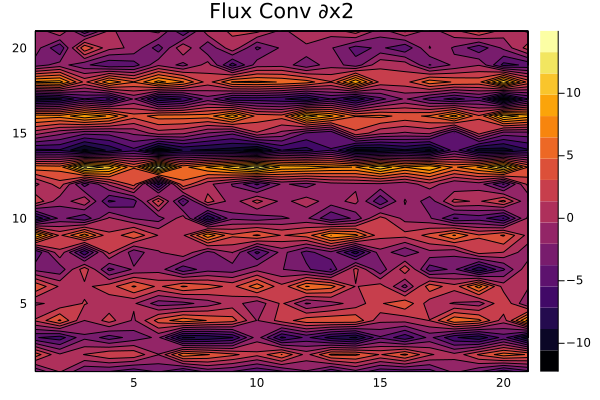

In [17]:
contourf(conv∂x2[:,:,1,1], title="Flux Conv ∂x2")

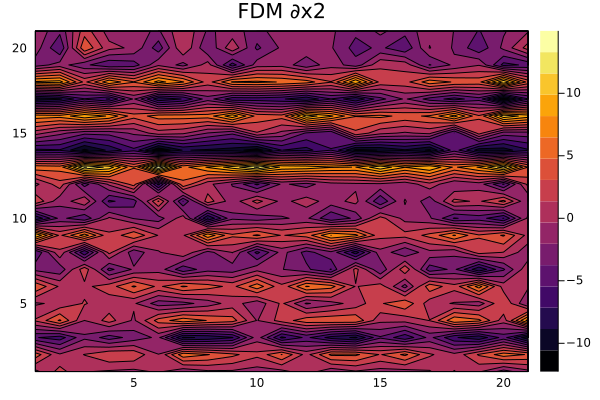

In [18]:
contourf(∂x2, title="FDM ∂x2")

### b) NNlib: Use same weights
Flux internally calls NNlib for neural network primitives

In [19]:
out = NNlib.conv(ϕconvPadded,weight∂x)

21×21×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
  -0.874537   2.00701     -0.253845  …  -0.096777   -2.84834   NaN
   4.05823   -0.102502     1.42477       3.26356     5.67944     4.61276
  -5.30693   -6.33816     -2.42324      -8.4593     -4.7282    -10.3775
   1.55175    5.00883     -0.353328      5.19163     0.385042    8.98442
  -0.576881   0.0626478    1.49602      -1.27423     3.00879    -2.23617
   4.65056    1.09863      0.943116  …   7.28397     0.591205   -0.0894318
  -2.56684   -3.27777      2.47124      -8.60869    -3.98264     1.01094
  -5.54798    1.0823      -6.9585        2.15461     1.30443    -1.51991
  10.0362     2.67591      7.38694       3.25404     4.97529     0.726343
  -8.83344   -3.20554     -5.17006      -4.63781    -7.24788     0.108419
   2.94421   -1.55296      1.14576   …   1.08839     3.5391     -2.03686
  -0.847942   2.38862     -4.57944      -1.15421    -5.63851     1.95188
   5.89018    5.53603     13.5117        8.34516    12.6236      4.68702
  -7.59858

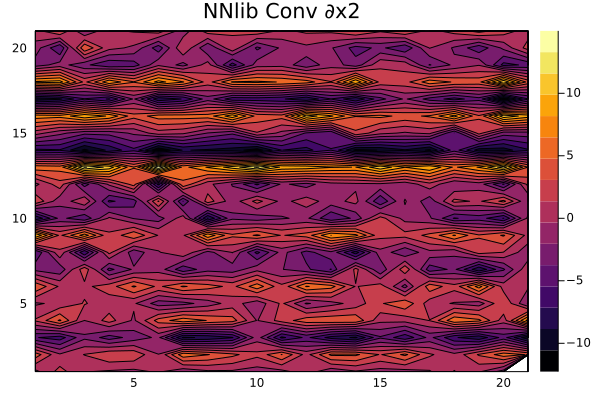

In [20]:
contourf(out[:,:,1,1], title="NNlib Conv ∂x2")

### c) Using DSP: Using signal processing package

In [21]:
outDSP = DSP.conv(ϕconv,weight∂x) #has implicit padding

23×23×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
  1.19209f-7    2.72939    2.16577      3.39554   …    3.40883    -1.19209f-7
 -1.06865f-7   -3.60393   -0.15876     -3.64938       -4.25343    -2.08616f-7
  1.78814f-7    4.05823   -0.102502     1.42477        4.61276     2.38419f-7
 -4.72601f-8   -5.30693   -6.33816     -2.42324      -10.3775     -4.01893f-7
  1.19209f-7    1.55175    5.00883     -0.353328       8.98442     4.76837f-7
 -1.91158f-7   -0.57688    0.0626473    1.49602   …   -2.23617    -2.08616f-7
  1.49012f-7    4.65056    1.09863      0.943116      -0.0894321  -2.38419f-7
 -2.91102f-7   -2.56684   -3.27777      2.47124        1.01094     1.30392f-7
  1.93715f-7   -5.54798    1.08231     -6.9585        -1.51991     6.51926f-8
  7.3757f-8    10.0362     2.67591      7.38694        0.726343   -2.06783f-7
 -2.98023f-8   -8.83344   -3.20554     -5.17006   …    0.108419    2.38419f-7
 -1.85735f-7    2.94421   -1.55296      1.14576       -2.03686    -1.30392f-7
  1.11759f-7   -0.84

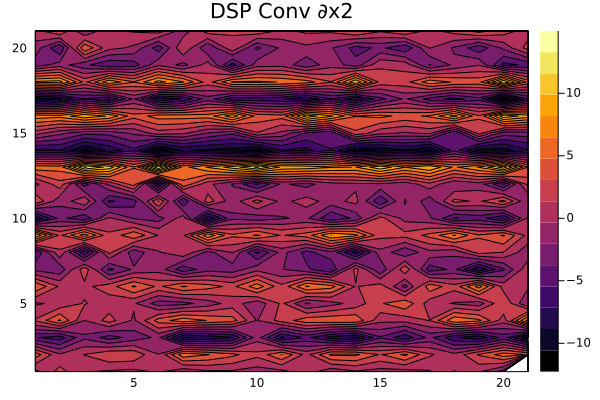

In [22]:
contourf(out[1:21,1:21,1,1], title="DSP Conv ∂x2")